<a href="https://colab.research.google.com/github/mezaga/guitar_VAE/blob/main/Copia_de_analisis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!pip install essentia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import essentia
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# there are two operating modes in essentia which (mostly) have the same algorithms
# they are accessible via two submodules:
import essentia.standard as es
import essentia.streaming

# let's have a look at what is in there
print(dir(essentia.standard))

['AfterMaxToBeforeMaxEnergyRatio', 'AllPass', 'AudioLoader', 'AudioOnsetsMarker', 'AudioWriter', 'AutoCorrelation', 'BFCC', 'BPF', 'BandPass', 'BandReject', 'BarkBands', 'BeatTrackerDegara', 'BeatTrackerMultiFeature', 'Beatogram', 'BeatsLoudness', 'BinaryOperator', 'BinaryOperatorStream', 'BpmHistogram', 'BpmHistogramDescriptors', 'BpmRubato', 'CartesianToPolar', 'CentralMoments', 'Centroid', 'ChordsDescriptors', 'ChordsDetection', 'ChordsDetectionBeats', 'ChromaCrossSimilarity', 'Chromagram', 'Chromaprinter', 'ClickDetector', 'Clipper', 'ConstantQ', 'CoverSongSimilarity', 'Crest', 'CrossCorrelation', 'CrossSimilarityMatrix', 'CubicSpline', 'DCRemoval', 'DCT', 'Danceability', 'Decrease', 'Derivative', 'DerivativeSFX', 'DiscontinuityDetector', 'Dissonance', 'DistributionShape', 'Duration', 'DynamicComplexity', 'ERBBands', 'EasyLoader', 'EffectiveDuration', 'Energy', 'EnergyBand', 'EnergyBandRatio', 'Entropy', 'Envelope', 'EqloudLoader', 'EqualLoudness', 'Extractor', 'FFT', 'FFTC', 'Fade

In [4]:
audiofile = '/content/MaxRichter.mp3'

# Compute all features.
# Aggregate 'mean' and 'stdev' statistics for all low-level, rhythm, and tonal frame features.
features, features_frames = es.MusicExtractor(lowlevelStats=['mean'])(audiofile)
caracteristicas = sorted(features.descriptorNames())
# See all feature names in the pool in a sorted order

In [ ]:
print(features['lowlevel.average_loudness'])

0.10552985966205597


In [ ]:
# Compute beat positions and BPM.
rhythm_extractor = es.RhythmExtractor2013(method="multifeature")
bpm, beats, beats_confidence, _, beats_intervals = rhythm_extractor(audio)

In [ ]:
audio = es.MonoLoader(filename='/content/MaxRichter.mp3')()
lowlevel = es.LowLevelSpectralExtractor()
result = lowlevel(audio)
print(result)

In [ ]:
audio = es.MonoLoader(filename='/content/drive/MyDrive/UNAM/audioLibrosa/salida2.wav')()
lowlevel = es.LowLevelSpectralExtractor()
result = lowlevel(audio)

In [9]:
sr = 44100
audios = ['/content/MaxRichter.mp3','/content/RubenBlandes.mp3'] 
names = ['el max','el Ruben']

In [10]:
waveforms = []
for track in audios:
    y,fs = librosa.load(track,sr)
    print(fs)
    waveforms.append(y)
waveforms = np.array(waveforms)
print(waveforms.shape)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


44100


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


44100
(2,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


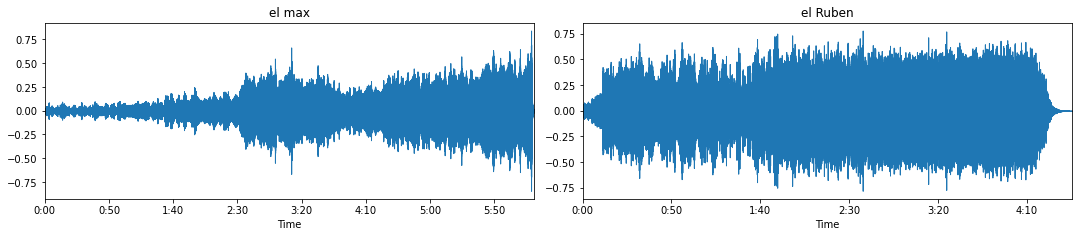

In [11]:
####visualización de los audios antes de normalizar
plt.figure(figsize=(15, 6))
for i in range(2):
  plt.subplot(2, 2, i+ 1).set_title(names[i])
  librosa.display.waveplot(waveforms[i], 44100)
plt.tight_layout()
#plt.title("Waveforms")
plt.show()

In [12]:
# Load audio file.

onset_Times = []

for i in range(len(audios)):
  audio = es.MonoLoader(filename= audios[i])()
  #od_hfc = es.OnsetDetection(method='hfc')
  od_complex = es.OnsetDetection(method='complex')

# We need the auxilary algorithms to compute magnitude and phase.
  w = es.Windowing(type='hann')
  fft = es.FFT() # Outputs a complex FFT vector.
  c2p = es.CartesianToPolar() # Converts it into a pair of magnitude and phase vectors.

  # Compute both ODF frame by frame. Store results to a Pool.
  pool = essentia.Pool()
  for frame in es.FrameGenerator(audio, frameSize=1024, hopSize=512):
      magnitude, phase = c2p(fft(w(frame)))
      #pool.add('odf.hfc', od_hfc(magnitude, phase))
      pool.add('odf.complex', od_complex(magnitude, phase))

  # 2. Detect onset locations.
  onsets = es.Onsets()
  onsets_complex = onsets(essentia.array([pool['odf.complex']]), [1])
  onset_Times.append(onsets_complex)

a = librosa.get_duration(waveforms[0], sr=sr)
b = librosa.get_duration(waveforms[1], sr=sr)

print(a)
print(b)

onset_Times[0] = np.insert(onset_Times[0],0,0)
onset_Times[1] = np.insert(onset_Times[0],0,0)

print(len(onset_Times))
print(len(onsets_complex))

381.1333333333333
275.35673469387757
2
1475


In [13]:
audioFragments = [[],[]]
for num,track in enumerate(onset_Times):
  #print(track)
  for times in range(len(track-1)):
    audioFragments[num].append(waveforms[num][int(track[(times)%len(track)]*sr): int(track[(times + 1)%len(track)]*sr)])

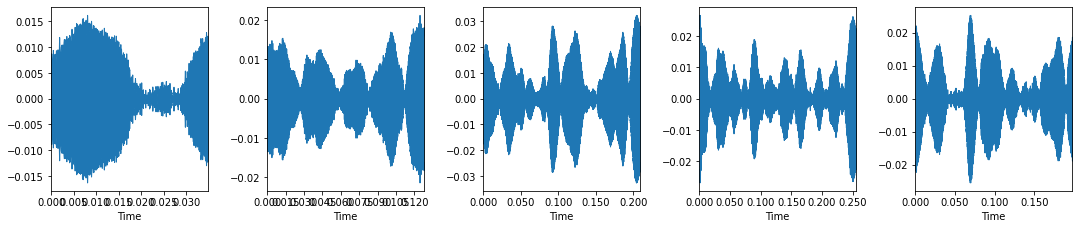

In [60]:
####visualización de los audios antes de normalizar
plt.figure(figsize=(15, 6))
for i in range(5):
  plt.subplot(2, 5, i+ 1)
  librosa.display.waveplot(audioFragments[0][i],sr)
plt.tight_layout()
#plt.title("Waveforms")
plt.show()

In [82]:
import IPython 
IPython.display.Audio(data= audioFragments[1][111], rate=sr)

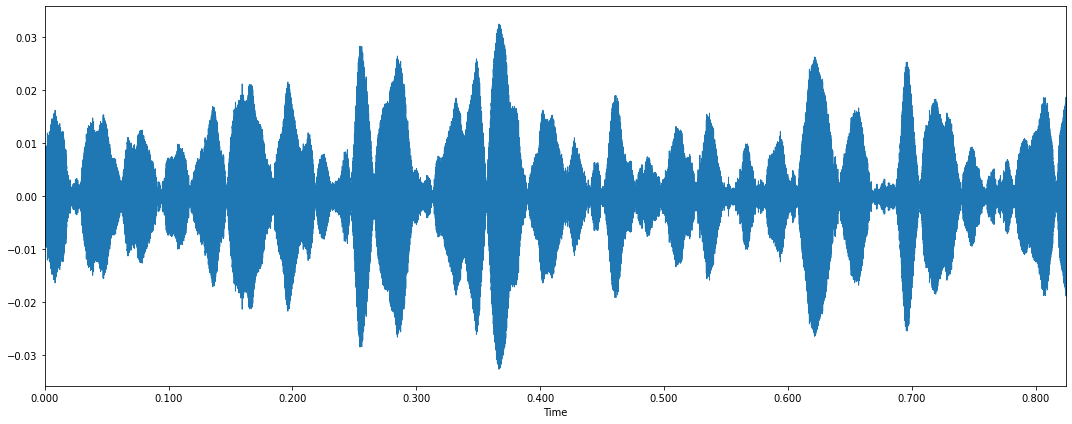

In [15]:
####visualización de los audios antes de normalizar
plt.figure(figsize=(15, 6))
librosa.display.waveplot(waveforms[0][:int(onset_Times[0][5]*sr)], 44100)
plt.tight_layout()
#plt.title("Waveforms")
plt.show()

In [16]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [93]:
import pydub 
import numpy as np

def writeMP3(x, sr, f, normalized=False):
    """numpy array to MP3"""
    channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
    if normalized:  # normalized array - each item should be a float in [-1, 1)
        y = np.int16(x * 2 ** 15)
    else:
        y = np.float32(x)
    song = pydub.AudioSegment(y.tobytes(), frame_rate= sr, sample_width= 4, channels= 1)
    song.export(f, format="wav")
    #files.download(song)

In [91]:
for i, composer in enumerate(audioFragments):  
  for j, fragments in enumerate(composer):
      writeMP3(fragments,sr,"audios/audio_"+names[i]+str(j)+".wav")

ValueError: ignored

In [79]:
audioFragments[0][0]

array([ 0.00819397,  0.00880432,  0.00695801, ..., -0.01170349,
       -0.01107788, -0.01054382], dtype=float32)

In [ ]:
audiofile = '/content/MaxRichter.mp3'
features, features_frames = es.MusicExtractor(lowlevelStats=['mean'])(audiofile)
a = features
print(type(a))

<class 'essentia.common.Pool'>


In [ ]:
data = []
for audio in audioFragments[:4]:
  audio_features, features_frames = es.MusicExtractor(lowlevelStats=['mean'])(audio)
  for num, features in enumerate(caracteristicas):
    print(recJson(audio_features,features))


data = np.array(data)
print(data.shape)

In [ ]:

def recJson(audio,descriptores):
  lista = []
  if isinstance(audio[descriptores], float) or isinstance(audio[descriptores], int):
      lista.append(audio[descriptores])
  elif isinstance(audio[descriptores], list):
      for hijohoja in audio[descriptores]:
        recJson(hijohoja, descriptores)
  elif isinstance(audio[descriptores], dict):
       for hijohoja in audio[descriptores].values():
        recJson(hijohoja, descriptores)
  return lista

In [59]:
print(len(audioFragments[1]))

818


In [ ]:
from google.colab import files
import os
for i in os.listdir('/content/audios'):  
 print(i)
 files.download(i)